In [53]:
import numpy as np 
import matplotlib.pyplot as plt 
from mpl_toolkits import mplot3d
import cmath as cm
from scipy import signal
import scipy.constants as const
from scipy.optimize import fsolve
%matplotlib widget 

Some code to explore the behavior of quantum particles in a periodic potential, such as electrons in a solid. Python's implementation of complex numbers is somewhat imperfect and I'm not smart enough to fix it so this code breaks sometimes. I think this usually occurs when the argument of a complex exponential is close to 2pi. If you just want to look at non-specific Bloch wavefunctions choose one such that a*q != 2 pi.


The equations here are slightly altered so that the computer doesn't run into floating point errors when dealing with extremely small numbers on the order of Planck's constant. To solve this I just removed Planck's constant from all equations, and also used particle masses and lattice distances of periodicity on the order of unity in meters.

In [124]:
def particle_in_box(x, a, n):
    return np.sqrt(2/a) * np.sin(n*np.pi*x/a)

def transcendental(k, q, a, m, alpha):
    return np.cos(k*a) + m*alpha/k * np.sin(k*a) - np.cos(q*a)

def plot_transcendental(a=0.5, m=2, alpha=10, top=50, ax=(None, 'Horizontal')):
    k = np.linspace(0.1, int(top), 50*int(top))
    f_z = np.cos(k*a) + m*alpha/k * np.sin(k*a)
    if ax[0] == None:
        fig_trans, ax_trans = plt.subplots()
        ax_trans.plot(k, f_z, label='f(k)', color='blue')
        ax_trans.axhline(y=1, color='r', linestyle='--')
        ax_trans.axhline(y=-1, color='r', linestyle='--')
        #ax_trans.axvline(x=np.pi/a*2, color='g', linestyle='--')
        fig_trans.show()
    elif ax[1]!='Vertical':
        ax[0].plot(k, f_z, label='f(k)', color='blue')
        ax[0].axhline(y=1, color='r', linestyle='--')
        ax[0].axhline(y=-1, color='r', linestyle='--')
        #ax[0].axvline(x=np.pi/a*2, color='g', linestyle='--')
    else:
        ax[0].plot(f_z, k, label='f(k)', color='blue')
        ax[0].axvline(x=1, color='r', linestyle='--')
        ax[0].axvline(x=-1, color='r', linestyle='--')
        #ax[0].axhline(y=np.pi/a*2, color='g', linestyle='--')

#plot_transcendental()

def comb_allowed_kq(a=0.5, m=2, alpha=10, N=5, want=10, step=None, plot=False):
    if step is None:
        step = np.pi/a
    found_kq_list = []
    k_guess = step
    while len(found_kq_list) < want:
        #print("current k guess:", k_guess)
        for n in range(N+1):
            q = 2*np.pi*n/(N*a)
            k_found = fsolve(transcendental, k_guess, (q, a, m, alpha))
            #print(f"k: {k_found[0]}   q: {q}")
            #print("err: ", transcendental(k_found[0], q, a, m, alpha))
            found_kq_list.append([k_found[0], q])
            if len(found_kq_list) >= want:
                break
        #print("\n")
        k_guess += step 
    arr = np.array(found_kq_list)
    sorted_arr = arr[arr[:, 0].argsort()]
    if plot:
        fig_temp, ax_temp = plt.subplots(1,2, figsize=(10, 5))
        for i in range(len(sorted_arr)):
            ax_temp[0].axhline(sorted_arr[i, 0])
        plot_transcendental(a, m, alpha, top=sorted_arr[-1,0], ax=(ax_temp[1], 'Vertical'))
        ax_temp[0].set_ylim(0, sorted_arr[-1, 0])
        ax_temp[1].set_ylim(0, sorted_arr[-1, 0])
        ax_temp[0].set_title('Allowed k values')
        ax_temp[0].set_ylabel('k')
        ax_temp[1].set_title('Transcendental Function of k')
        ax_temp[1].set_ylabel('k')
        ax_temp[1].set_xlabel('f(k)')
        fig_temp.tight_layout()
    return sorted_arr

#print(comb_allowed_kq(N=20, want=100, plot=True))
    

def comb_wf(x, a, k, q):
    return np.sin(k*x) + np.exp(-1j*q*a)*np.sin(k*(a-x))


def dirac_comb(a, alpha, N, grain=100):
    x = np.linspace(0, a*N, a*N*grain, dtype=np.float64)
    potential = np.zeros_like(x)
    length = potential.size
    for i in range(N):
        potential = potential + alpha*signal.unit_impulse(length, i*a*grain)
    return x, potential


def plot_wf(x, wf, potential=None, xlim=None):
    fig = plt.figure(figsize=(10, 5))

    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122)

    # defining all 3 axis
    Re = np.real(wf)
    Im = np.imag(wf)
    wf1_mag = np.abs(wf)
    # plotting
    if potential is not None:
        wf1_mag_max = np.max(wf1_mag)
        pot_max = np.max(potential)
        conv = wf1_mag_max/pot_max
        ax1.plot3D(x, np.zeros_like(x), potential*conv, 'black')
        ax2.plot(x, potential*conv, 'black')
    ax1.plot3D(x, Im, Re, 'green')
    ax1.set_title('Complex Wavefunction')
    ax1.set_xlabel('x')
    ax1.set_ylabel('Im')
    ax1.set_zlabel('Re')

    ax2.plot(x,wf1_mag, 'green')
    ax2.set_title('Magnitude of Wavefunction')
    ax2.set_xlabel('x')
    ax2.set_ylabel('|Psi|')
    fig.tight_layout()

    if xlim is not None:
        ax1.set_xlim(xlim)
        ax2.set_xlim(xlim)
        ax1.set_box_aspect([2, 1, 1])
    plt.show()

In [125]:
'''
def transcendental(k, q, a, m, alpha):
    return np.cos(k*a) + m*alpha/(const.hbar**2 * k) * np.sin(k*a) - np.cos(q*a)

def comb_allowed_k(a=const.value("Bohr radius"), m=const.electron_mass, alpha=4, N=10**23, want=10, step=0.1):
    found_kq_list = []
    k_guess = step
    while len(found_kq_list) < want:
        for n in range(N):
            q = 2*np.pi*n/(N*a)
            k_found = fsolve(transcendental, k_guess, (q, a, m, alpha))
            print(k_found[0])
            print("err: ", transcendental(k_found[0], q, a, m, alpha))
            found_kq_list.append([k_found[0], q])
            if len(found_kq_list) >= want:
                break
        k_guess += step 
    return np.array(found_kq_list)

print(comb_allowed_k())
'''

'\ndef transcendental(k, q, a, m, alpha):\n    return np.cos(k*a) + m*alpha/(const.hbar**2 * k) * np.sin(k*a) - np.cos(q*a)\n\ndef comb_allowed_k(a=const.value("Bohr radius"), m=const.electron_mass, alpha=4, N=10**23, want=10, step=0.1):\n    found_kq_list = []\n    k_guess = step\n    while len(found_kq_list) < want:\n        for n in range(N):\n            q = 2*np.pi*n/(N*a)\n            k_found = fsolve(transcendental, k_guess, (q, a, m, alpha))\n            print(k_found[0])\n            print("err: ", transcendental(k_found[0], q, a, m, alpha))\n            found_kq_list.append([k_found[0], q])\n            if len(found_kq_list) >= want:\n                break\n        k_guess += step \n    return np.array(found_kq_list)\n\nprint(comb_allowed_k())\n'

k: 6.179032882701535 
q: 0.6283185307179586


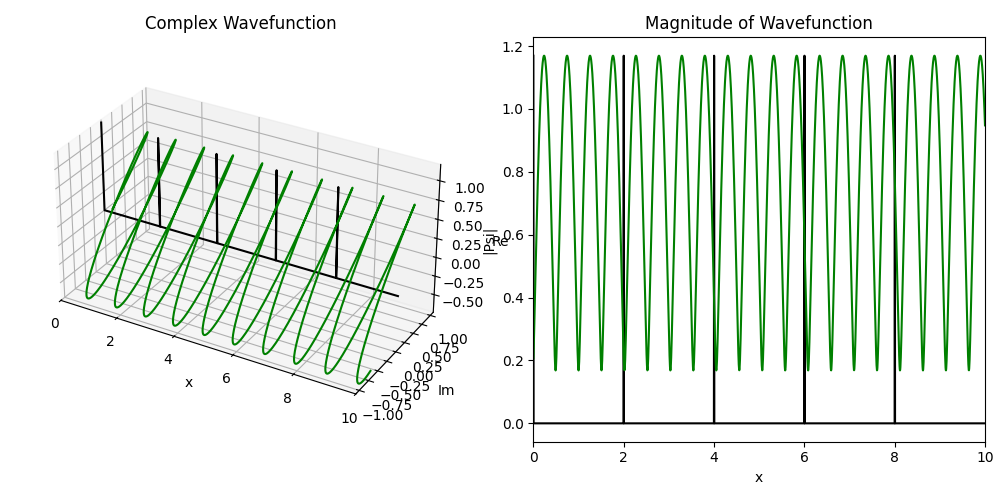

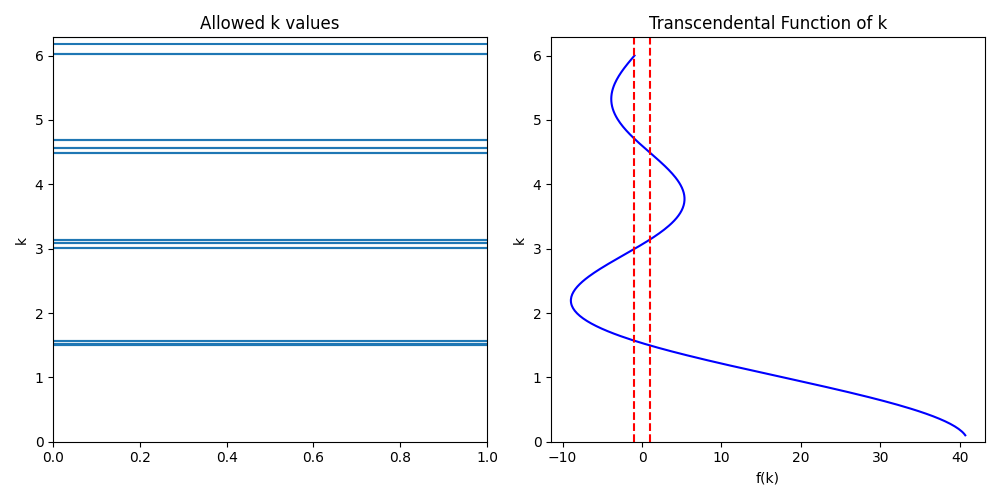

In [126]:
###Visualization###

a=2     #lattice spacing (m)
m=2     # mass of particle (kg) lol
alpha=10    # strength of dirac comb potential (J?)
N=5       # Number of lattice spikes
i=20       # index of kq pair to visualize
top = i+2   # number of kq pairs for code to find 
x, comb = dirac_comb(a, alpha, N, grain=a*N*top)    # grain is x axis resolution, 
                                                    # this expression gives a reasonable resolution for arbitrary N, a and i 
# print(comb)

kq = comb_allowed_kq(a, m, alpha, N, want=top, plot=True)   # Solves transcendental equation to find kq pairs
#print(kq)
wf = comb_wf(x, a, kq[i,0], kq[i,1])
print(f"k: {kq[i,0]} \nq: {kq[i,1]}")                   # prints selected values of k and associated q to visualize
plot_wf(x, wf, comb, xlim=(0, a*5))                   # plots wavefunction and potential in complex space and magnitude space


k: 78.03187141124117 
q: 2.5132741228718345


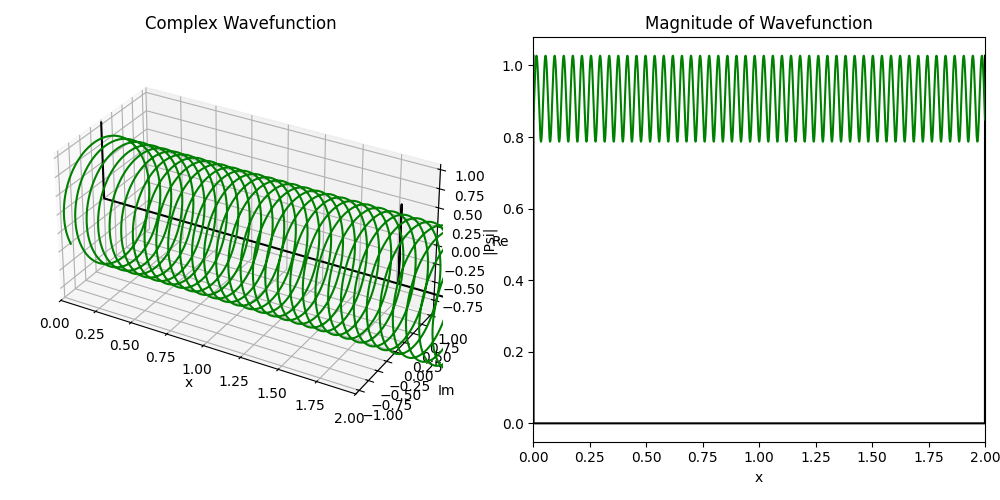

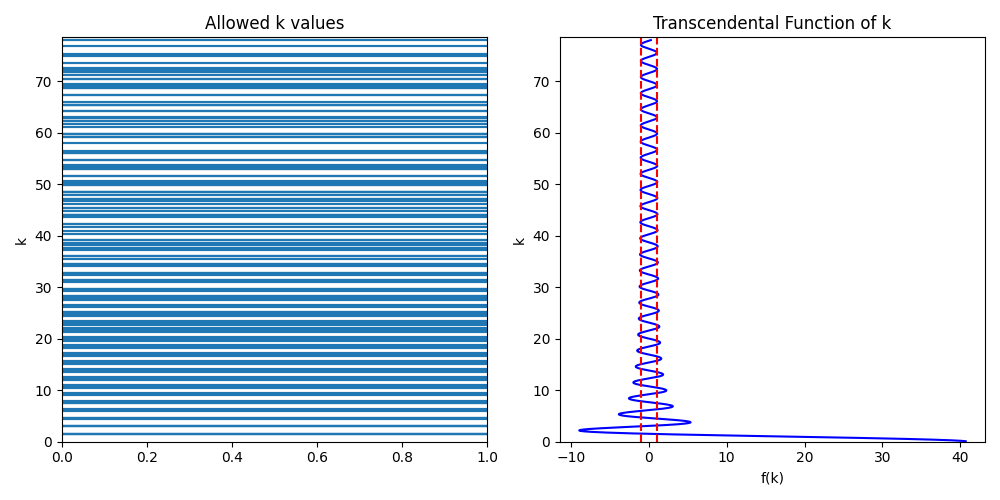

In [127]:
a=2
m=2
alpha=10
N=5
i=297
top = i+2
x, comb = dirac_comb(a, alpha, N, grain=a*N*top)
#print(comb)
kq = comb_allowed_kq(a, m, alpha, N, want=top, plot=True)
#print(kq)
wf = comb_wf(x, a, kq[i,0], kq[i,1])
print(f"k: {kq[i,0]} \nq: {kq[i,1]}")                   # prints selected values of k and associated q to visualize
plot_wf(x, wf, comb, xlim=(0, a))

In [128]:
skribbity

NameError: name 'skribbity' is not defined